## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [90]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Загружаем исходные данные

In [92]:
train = np.loadtxt('./data/all/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/all/test.csv', delimiter=',', skiprows=1)

In [93]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [94]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

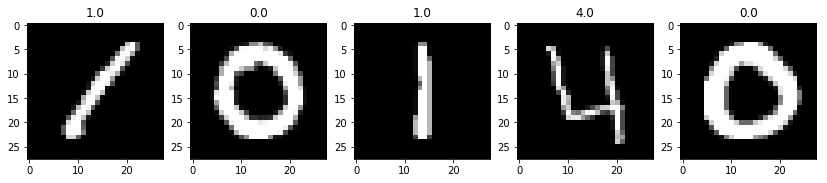

In [95]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [228]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [229]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [230]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [231]:
train_g.shape, train_theta.shape

((42000, 28, 28), (42000, 28, 28))

In [232]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

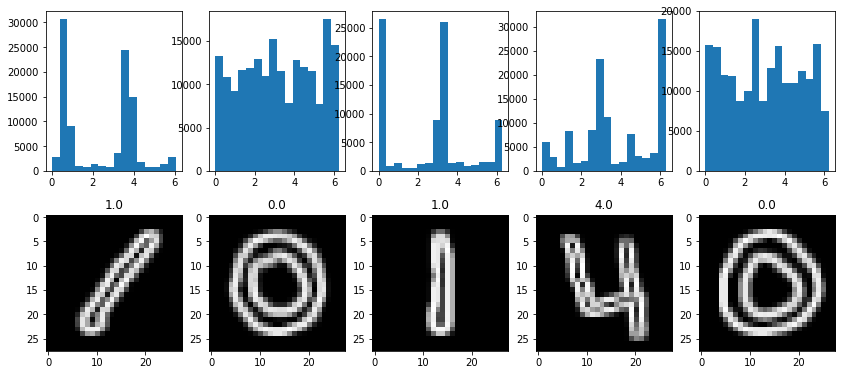

In [233]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [111]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [112]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [113]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [114]:
train_hist[1,:]

array([ 0.26896544,  0.23188415,  0.17378102,  0.23513087,  0.2399041 ,
        0.2938771 ,  0.19154815,  0.30779731,  0.26377303,  0.18753374,
        0.23565425,  0.20968733,  0.28618426,  0.10979111,  0.37961404,
        0.26597783])

In [115]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [116]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [31]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [32]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [33]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [34]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.427023809524


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.34      0.12      0.18       816
        1.0       0.59      0.76      0.66       909
        2.0       0.33      0.29      0.31       846
        3.0       0.55      0.49      0.51       937
        4.0       0.33      0.31      0.32       839
        5.0       0.46      0.67      0.55       702
        6.0       0.24      0.45      0.31       785
        7.0       0.73      0.41      0.53       893
        8.0       0.39      0.49      0.44       835
        9.0       0.48      0.27      0.34       838

avg / total       0.45      0.43      0.42      8400



In [36]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


## Предсказания на тестовыйх данных

In [23]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

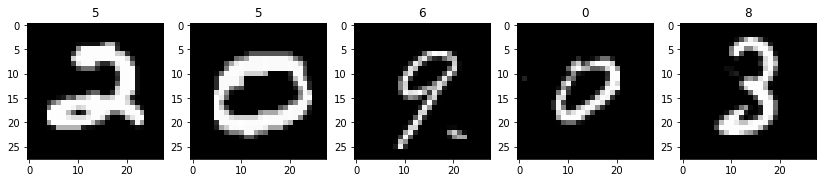

In [24]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

# Calculate for 4 part hist features

In [96]:
def calc_hist_features(img):
    
    hist_img = np.zeros((len(img), 16*4))   

    for i in range(len(img)):
    #calculate for n parts of image and concatenate histograms
        (h, w) = img[i].shape[:2]  # размеры изображения
        (cX, cY) = (int(w * 0.5), int(h * 0.5))  # координаты центра изображения
        # делим изображение на четыре равные части
        # и вычисляем координаты сегментов
        segments = [(0, cX, 0, cY), 
                    (cX, w, 0, cY),
                    (cX, w, cY, h),
                    (0, cX, cY, h)]
#         print(segments)
        features = []
        for (startX, endX, startY, endY) in segments:
            img_part = img[i][startX:endX, startY:endY]
            sobel_x = cv2.Sobel(img_part, cv2.CV_64F, dx=1, dy=0, ksize=3)
            sobel_y = cv2.Sobel(img_part, cv2.CV_64F, dx=0, dy=1, ksize=3)

            g, theta = cv2.cartToPolar(sobel_x, sobel_y)

            hist, borders = np.histogram(theta,
                                         bins=16,
                                         range=(0., 2. * np.pi),
                                         weights = g)
            features.extend(hist.flatten())
#             if hist_vec is None:
#                 hist_vec = hist
#             else:
#                 hist_vec = np.hstack((hist_vec, hist))
#         print(features)
        hist_img[i] = np.array(features) / np.linalg.norm(np.array(features) , axis=0)

    return hist_img    

In [98]:
hist4_train = calc_hist_features(train_img)

In [99]:
hist4_test = calc_hist_features(test_img)

In [100]:
x_train, x_val, y_train, y_val = train_test_split(
    hist4_train, train_label, test_size=0.2,
    random_state=42)

In [103]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)

In [104]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [105]:
print(clf.feature_importances_)

[ 0.00727324  0.01708863  0.02344461  0.00761351  0.0133126   0.00384383
  0.00915965  0.01096475  0.05648647  0.00974139  0.00238439  0.00511088
  0.03197907  0.04115369  0.03511441  0.00661232  0.00616391  0.01112478
  0.00790607  0.0148623   0.01378387  0.01305415  0.02231794  0.02584845
  0.02540475  0.00963668  0.00213816  0.00342095  0.02718008  0.01100569
  0.00194472  0.00364154  0.04128098  0.01866159  0.02227891  0.00414624
  0.01741138  0.01133259  0.01357355  0.00747282  0.00458259  0.0008934
  0.02055134  0.00947012  0.03153339  0.00251209  0.00992486  0.01194221
  0.0330602   0.01029972  0.00272314  0.00406104  0.02331261  0.00118498
  0.00439967  0.00458821  0.01518722  0.00423778  0.00433548  0.03307125
  0.06102227  0.02547429  0.04827037  0.01648622]


In [106]:
pred_val = clf.predict(x_val)

In [108]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.887142857143


In [110]:
print(confusion_matrix(y_val, pred_val))

[[799   0   1   3   1   0   8   0   2   2]
 [  0 892   6   2   1   0   2   4   1   1]
 [  7   7 778  26   3   0   2   3  12   8]
 [  3   1  19 887   1   3   1   6   7   9]
 [ 11   6   0   0 714   0  45   4   3  56]
 [  6   0   1  34   2 634  14   1   7   3]
 [ 48   5   0   1  21   7 698   0   2   3]
 [  8   4  59  29   2   0   1 714   0  76]
 [ 23  12   7  19  16  13  49  12 633  51]
 [ 28   8   0  11  28   9   9  34   8 703]]


In [111]:
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.86      0.98      0.91       816
        1.0       0.95      0.98      0.97       909
        2.0       0.89      0.92      0.91       846
        3.0       0.88      0.95      0.91       937
        4.0       0.90      0.85      0.88       839
        5.0       0.95      0.90      0.93       702
        6.0       0.84      0.89      0.86       785
        7.0       0.92      0.80      0.85       893
        8.0       0.94      0.76      0.84       835
        9.0       0.77      0.84      0.80       838

avg / total       0.89      0.89      0.89      8400



# PCA features


In [18]:
X = np.vstack((train_img, test_img)).reshape((-1,28*28))
X.shape

(70000, 784)

In [22]:
train_len, test_len = train_img.shape[0], test_img.shape[0]
print(train_len, test_len)

42000 28000


In [81]:
#Create PCA features
features_length = 128
pca = decomposition.PCA(n_components=features_length)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

In [82]:
pca.components_.shape

(128, 784)

In [83]:
X_train, X_test = X_pca[0:train_len,:], X_pca[train_len: train_len+test_len,:]

In [84]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, train_label, test_size=0.2,
    random_state=42)
x_train.shape

(33600, 128)

In [85]:
scaler = StandardScaler()

In [86]:
x_train_scaled = scaler.fit_transform(x_train)

In [87]:
x_val_scaled = scaler.transform(x_val)

## Logistic regression

In [88]:
clf_log_reg = LogisticRegression(solver='sag', max_iter=10000, random_state=42, 
                         multi_class='multinomial').fit(x_train_scaled, y_train)

In [89]:
predict_val = clf_log_reg.predict(x_val_scaled)

In [90]:
print('Accuracy: %s' % accuracy_score(y_val, predict_val))

Accuracy: 0.917023809524


In [92]:
print(classification_report(y_val, predict_val))

             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96       816
        1.0       0.96      0.98      0.97       909
        2.0       0.92      0.89      0.90       846
        3.0       0.91      0.88      0.89       937
        4.0       0.91      0.93      0.92       839
        5.0       0.85      0.87      0.86       702
        6.0       0.92      0.96      0.94       785
        7.0       0.93      0.92      0.92       893
        8.0       0.90      0.89      0.89       835
        9.0       0.89      0.90      0.89       838

avg / total       0.92      0.92      0.92      8400



In [93]:
print(confusion_matrix(y_val, predict_val))

[[789   0   2   0   2  10   8   2   2   1]
 [  0 889   2   2   1   4   1   2   6   2]
 [  5  10 753  10  14   8  13  11  21   1]
 [  2   3  20 821   0  40   3  11  23  14]
 [  3   2   6   1 777   2  10   3   1  34]
 [  8   4   8  21  12 610  18   2  16   3]
 [  7   1   8   0   6   6 753   1   3   0]
 [  1   1  13   4  13   3   0 821   4  33]
 [  4  11   5  25   5  26  10   2 739   8]
 [  5   3   3  14  20   7   0  30   5 751]]


## Random forest 

In [94]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)

In [95]:
clf.fit(x_train_scaled ,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [96]:
pred_val = clf.predict(x_val_scaled)

In [97]:
print('Accuracy: %s' % accuracy_score(y_val, predict_val))

Accuracy: 0.917023809524


In [240]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)

In [241]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [242]:
print(clf.feature_importances_)

[ 0.00727324  0.01708863  0.02344461  0.00761351  0.0133126   0.00384383
  0.00915965  0.01096475  0.05648647  0.00974139  0.00238439  0.00511088
  0.03197907  0.04115369  0.03511441  0.00661232  0.00616391  0.01112478
  0.00790607  0.0148623   0.01378387  0.01305415  0.02231794  0.02584845
  0.02540475  0.00963668  0.00213816  0.00342095  0.02718008  0.01100569
  0.00194472  0.00364154  0.04128098  0.01866159  0.02227891  0.00414624
  0.01741138  0.01133259  0.01357355  0.00747282  0.00458259  0.0008934
  0.02055134  0.00947012  0.03153339  0.00251209  0.00992486  0.01194221
  0.0330602   0.01029972  0.00272314  0.00406104  0.02331261  0.00118498
  0.00439967  0.00458821  0.01518722  0.00423778  0.00433548  0.03307125
  0.06102227  0.02547429  0.04827037  0.01648622]


In [243]:
pred_val = clf.predict(x_val)

In [244]:
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.86      0.98      0.91       816
        1.0       0.95      0.98      0.97       909
        2.0       0.89      0.92      0.91       846
        3.0       0.88      0.95      0.91       937
        4.0       0.90      0.85      0.88       839
        5.0       0.95      0.90      0.93       702
        6.0       0.84      0.89      0.86       785
        7.0       0.92      0.80      0.85       893
        8.0       0.94      0.76      0.84       835
        9.0       0.77      0.84      0.80       838

avg / total       0.89      0.89      0.89      8400



In [245]:
print(confusion_matrix(y_val, pred_val))

[[799   0   1   3   1   0   8   0   2   2]
 [  0 892   6   2   1   0   2   4   1   1]
 [  7   7 778  26   3   0   2   3  12   8]
 [  3   1  19 887   1   3   1   6   7   9]
 [ 11   6   0   0 714   0  45   4   3  56]
 [  6   0   1  34   2 634  14   1   7   3]
 [ 48   5   0   1  21   7 698   0   2   3]
 [  8   4  59  29   2   0   1 714   0  76]
 [ 23  12   7  19  16  13  49  12 633  51]
 [ 28   8   0  11  28   9   9  34   8 703]]


In [246]:
pred_test = clf.predict(hist4_test)

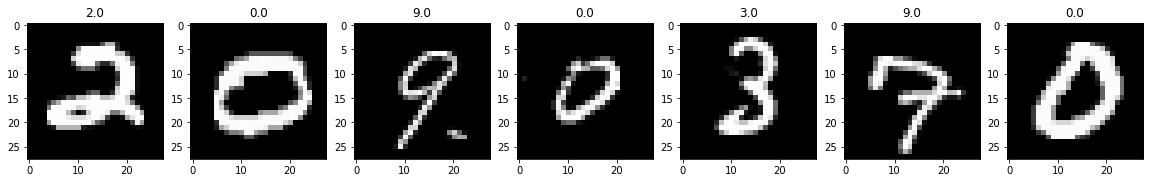

In [247]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

# HOG features


In [141]:
def calculateHOG(img_list):
    
    hist_features = None

    cell_size = (8, 8)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    img = img_list[0]
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)    
    
    for i in tqdm(range(len(img_list))):
        img = img_list[i].astype(np.uint8)
#         n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
        hog_feats = hog.compute(img)#\
#                        .reshape(n_cells[1] - block_size[1] + 1,
#                                 n_cells[0] - block_size[0] + 1,
#                                 block_size[0], block_size[1], nbins) \
#                        .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
                
        if hist_features is None:
            hist_features = np.expand_dims(hog_feats,axis =0)
        else:
            hist_features = np.vstack((hist_features,  np.expand_dims(hog_feats,axis =0)))
        
    return hist_features

In [142]:
hog_train = calculateHOG(train_img)





  0%|                                                                                        | 0/42000 [00:00<?, ?it/s]



  3%|█▉                                                                        | 1089/42000 [00:00<00:03, 10781.59it/s]



  4%|██▉                                                                        | 1614/42000 [00:00<00:05, 8029.39it/s]



  5%|███▌                                                                       | 2001/42000 [00:00<00:08, 4620.98it/s]



  6%|████▏                                                                      | 2322/42000 [00:00<00:11, 3424.58it/s]



  6%|████▌                                                                      | 2587/42000 [00:00<00:14, 2784.56it/s]



  7%|█████                                                                      | 2804/42000 [00:01<00:15, 2474.70it/s]



  7%|█████▎                                                                     | 2988/42000 [00:01<00:17, 2266.94it/s]



  7%|█████▌ 

 15%|███████████▍                                                                | 6295/42000 [00:08<00:47, 758.85it/s]



 15%|███████████▍                                                                | 6323/42000 [00:08<00:47, 752.78it/s]



 15%|███████████▍                                                                | 6351/42000 [00:08<00:47, 746.61it/s]



 15%|███████████▌                                                                | 6388/42000 [00:08<00:47, 742.23it/s]



 15%|███████████▌                                                                | 6424/42000 [00:08<00:48, 737.84it/s]



 15%|███████████▋                                                                | 6456/42000 [00:08<00:48, 733.01it/s]



 15%|███████████▋                                                                | 6488/42000 [00:08<00:48, 727.88it/s]



 16%|███████████▊                                                                | 6522/42000 [00:09<00:49, 723.42it/s]



 16%|███████████

 21%|███████████████▊                                                            | 8715/42000 [00:15<00:57, 575.40it/s]



 21%|███████████████▊                                                            | 8747/42000 [00:15<00:57, 573.73it/s]



 21%|███████████████▉                                                            | 8779/42000 [00:15<00:58, 572.04it/s]



 21%|███████████████▉                                                            | 8811/42000 [00:15<00:58, 569.78it/s]



 21%|███████████████▉                                                            | 8842/42000 [00:15<00:58, 567.85it/s]



 21%|████████████████                                                            | 8872/42000 [00:15<00:58, 566.07it/s]



 21%|████████████████                                                            | 8904/42000 [00:15<00:58, 564.51it/s]



 21%|████████████████▏                                                           | 8935/42000 [00:15<00:58, 562.91it/s]



 21%|███████████

 25%|███████████████████                                                        | 10673/42000 [00:22<01:04, 483.66it/s]



 25%|███████████████████                                                        | 10700/42000 [00:22<01:04, 482.67it/s]



 26%|███████████████████▏                                                       | 10727/42000 [00:22<01:04, 481.70it/s]



 26%|███████████████████▏                                                       | 10754/42000 [00:22<01:04, 480.75it/s]



 26%|███████████████████▎                                                       | 10781/42000 [00:22<01:05, 479.77it/s]



 26%|███████████████████▎                                                       | 10808/42000 [00:22<01:05, 478.77it/s]



 26%|███████████████████▎                                                       | 10835/42000 [00:22<01:05, 477.77it/s]



 26%|███████████████████▍                                                       | 10862/42000 [00:22<01:05, 476.77it/s]



 26%|███████████

 29%|██████████████████████                                                     | 12326/42000 [00:28<01:09, 425.69it/s]



 29%|██████████████████████                                                     | 12349/42000 [00:29<01:09, 424.95it/s]



 29%|██████████████████████                                                     | 12373/42000 [00:29<01:09, 424.29it/s]



 30%|██████████████████████▏                                                    | 12397/42000 [00:29<01:09, 423.59it/s]



 30%|██████████████████████▏                                                    | 12420/42000 [00:29<01:09, 422.76it/s]



 30%|██████████████████████▏                                                    | 12443/42000 [00:29<01:10, 421.99it/s]



 30%|██████████████████████▎                                                    | 12465/42000 [00:29<01:10, 421.28it/s]



 30%|██████████████████████▎                                                    | 12488/42000 [00:29<01:10, 420.65it/s]



 30%|███████████

 33%|████████████████████████▋                                                  | 13831/42000 [00:35<01:12, 386.11it/s]



 33%|████████████████████████▋                                                  | 13852/42000 [00:35<01:13, 385.58it/s]



 33%|████████████████████████▊                                                  | 13873/42000 [00:36<01:13, 385.04it/s]



 33%|████████████████████████▊                                                  | 13894/42000 [00:36<01:13, 384.51it/s]



 33%|████████████████████████▊                                                  | 13915/42000 [00:36<01:13, 383.90it/s]



 33%|████████████████████████▉                                                  | 13935/42000 [00:36<01:13, 383.37it/s]



 33%|████████████████████████▉                                                  | 13955/42000 [00:36<01:13, 382.84it/s]



 33%|████████████████████████▉                                                  | 13975/42000 [00:36<01:13, 382.32it/s]



 33%|███████████

 36%|███████████████████████████                                                | 15165/42000 [00:42<01:15, 354.09it/s]



 36%|███████████████████████████                                                | 15184/42000 [00:42<01:15, 353.66it/s]



 36%|███████████████████████████▏                                               | 15202/42000 [00:43<01:15, 353.24it/s]



 36%|███████████████████████████▏                                               | 15220/42000 [00:43<01:15, 352.78it/s]



 36%|███████████████████████████▏                                               | 15238/42000 [00:43<01:15, 352.26it/s]



 36%|███████████████████████████▏                                               | 15256/42000 [00:43<01:16, 351.67it/s]



 36%|███████████████████████████▎                                               | 15275/42000 [00:43<01:16, 351.27it/s]



 36%|███████████████████████████▎                                               | 15292/42000 [00:43<01:16, 350.84it/s]



 36%|███████████

 39%|█████████████████████████████▏                                             | 16340/42000 [00:49<01:18, 327.36it/s]



 39%|█████████████████████████████▏                                             | 16359/42000 [00:50<01:18, 327.05it/s]



 39%|█████████████████████████████▏                                             | 16378/42000 [00:50<01:18, 326.76it/s]



 39%|█████████████████████████████▎                                             | 16397/42000 [00:50<01:18, 326.47it/s]



 39%|█████████████████████████████▎                                             | 16415/42000 [00:50<01:18, 326.16it/s]



 39%|█████████████████████████████▎                                             | 16434/42000 [00:50<01:18, 325.87it/s]



 39%|█████████████████████████████▍                                             | 16453/42000 [00:50<01:18, 325.58it/s]



 39%|█████████████████████████████▍                                             | 16472/42000 [00:50<01:18, 325.27it/s]



 39%|███████████

 42%|███████████████████████████████▎                                           | 17546/42000 [00:56<01:19, 309.16it/s]



 42%|███████████████████████████████▎                                           | 17564/42000 [00:56<01:19, 308.91it/s]



 42%|███████████████████████████████▍                                           | 17582/42000 [00:56<01:19, 308.66it/s]



 42%|███████████████████████████████▍                                           | 17600/42000 [00:57<01:19, 308.41it/s]



 42%|███████████████████████████████▍                                           | 17618/42000 [00:57<01:19, 308.16it/s]



 42%|███████████████████████████████▍                                           | 17636/42000 [00:57<01:19, 307.90it/s]



 42%|███████████████████████████████▌                                           | 17654/42000 [00:57<01:19, 307.65it/s]



 42%|███████████████████████████████▌                                           | 17672/42000 [00:57<01:19, 307.41it/s]



 42%|███████████

 44%|█████████████████████████████████▎                                         | 18684/42000 [01:03<01:19, 293.86it/s]



 45%|█████████████████████████████████▍                                         | 18701/42000 [01:03<01:19, 293.64it/s]



 45%|█████████████████████████████████▍                                         | 18718/42000 [01:03<01:19, 293.43it/s]



 45%|█████████████████████████████████▍                                         | 18735/42000 [01:03<01:19, 293.21it/s]



 45%|█████████████████████████████████▍                                         | 18752/42000 [01:04<01:19, 293.00it/s]



 45%|█████████████████████████████████▌                                         | 18769/42000 [01:04<01:19, 292.79it/s]



 45%|█████████████████████████████████▌                                         | 18786/42000 [01:04<01:19, 292.58it/s]



 45%|█████████████████████████████████▌                                         | 18803/42000 [01:04<01:19, 292.35it/s]



 45%|███████████

 47%|███████████████████████████████████▎                                       | 19759/42000 [01:10<01:19, 280.59it/s]



 47%|███████████████████████████████████▎                                       | 19775/42000 [01:10<01:19, 280.40it/s]



 47%|███████████████████████████████████▎                                       | 19791/42000 [01:10<01:19, 280.21it/s]



 47%|███████████████████████████████████▎                                       | 19807/42000 [01:10<01:19, 280.03it/s]



 47%|███████████████████████████████████▍                                       | 19823/42000 [01:10<01:19, 279.85it/s]



 47%|███████████████████████████████████▍                                       | 19839/42000 [01:10<01:19, 279.65it/s]



 47%|███████████████████████████████████▍                                       | 19855/42000 [01:11<01:19, 279.46it/s]



 47%|███████████████████████████████████▍                                       | 19871/42000 [01:11<01:19, 279.28it/s]



 47%|███████████

 50%|█████████████████████████████████████▏                                     | 20792/42000 [01:17<01:18, 269.01it/s]



 50%|█████████████████████████████████████▏                                     | 20807/42000 [01:17<01:18, 268.85it/s]



 50%|█████████████████████████████████████▏                                     | 20822/42000 [01:17<01:18, 268.69it/s]



 50%|█████████████████████████████████████▏                                     | 20837/42000 [01:17<01:18, 268.53it/s]



 50%|█████████████████████████████████████▏                                     | 20852/42000 [01:17<01:18, 268.38it/s]



 50%|█████████████████████████████████████▎                                     | 20867/42000 [01:17<01:18, 268.22it/s]



 50%|█████████████████████████████████████▎                                     | 20882/42000 [01:17<01:18, 268.06it/s]



 50%|█████████████████████████████████████▎                                     | 20897/42000 [01:18<01:18, 267.89it/s]



 50%|███████████

 52%|██████████████████████████████████████▉                                    | 21781/42000 [01:24<01:18, 258.73it/s]



 52%|██████████████████████████████████████▉                                    | 21795/42000 [01:24<01:18, 258.56it/s]



 52%|██████████████████████████████████████▉                                    | 21810/42000 [01:24<01:18, 258.41it/s]



 52%|██████████████████████████████████████▉                                    | 21825/42000 [01:24<01:18, 258.27it/s]



 52%|███████████████████████████████████████                                    | 21840/42000 [01:24<01:18, 258.12it/s]



 52%|███████████████████████████████████████                                    | 21854/42000 [01:24<01:18, 257.97it/s]



 52%|███████████████████████████████████████                                    | 21869/42000 [01:24<01:18, 257.83it/s]



 52%|███████████████████████████████████████                                    | 21883/42000 [01:24<01:18, 257.68it/s]



 52%|███████████

 54%|████████████████████████████████████████▌                                  | 22710/42000 [01:30<01:17, 249.62it/s]



 54%|████████████████████████████████████████▌                                  | 22724/42000 [01:31<01:17, 249.48it/s]



 54%|████████████████████████████████████████▌                                  | 22738/42000 [01:31<01:17, 249.36it/s]



 54%|████████████████████████████████████████▋                                  | 22752/42000 [01:31<01:17, 249.23it/s]



 54%|████████████████████████████████████████▋                                  | 22766/42000 [01:31<01:17, 249.10it/s]



 54%|████████████████████████████████████████▋                                  | 22780/42000 [01:31<01:17, 248.97it/s]



 54%|████████████████████████████████████████▋                                  | 22794/42000 [01:31<01:17, 248.84it/s]



 54%|████████████████████████████████████████▋                                  | 22808/42000 [01:31<01:17, 248.71it/s]



 54%|███████████

 56%|██████████████████████████████████████████▏                                | 23634/42000 [01:37<01:16, 241.29it/s]



 56%|██████████████████████████████████████████▏                                | 23648/42000 [01:38<01:16, 241.17it/s]



 56%|██████████████████████████████████████████▎                                | 23662/42000 [01:38<01:16, 241.05it/s]



 56%|██████████████████████████████████████████▎                                | 23675/42000 [01:38<01:16, 240.93it/s]



 56%|██████████████████████████████████████████▎                                | 23688/42000 [01:38<01:16, 240.82it/s]



 56%|██████████████████████████████████████████▎                                | 23701/42000 [01:38<01:16, 240.71it/s]



 56%|██████████████████████████████████████████▎                                | 23714/42000 [01:38<01:16, 240.59it/s]



 56%|██████████████████████████████████████████▎                                | 23728/42000 [01:38<01:15, 240.48it/s]



 57%|███████████

 58%|███████████████████████████████████████████▋                               | 24499/42000 [01:44<01:14, 233.86it/s]



 58%|███████████████████████████████████████████▊                               | 24512/42000 [01:44<01:14, 233.75it/s]



 58%|███████████████████████████████████████████▊                               | 24525/42000 [01:44<01:14, 233.64it/s]



 58%|███████████████████████████████████████████▊                               | 24538/42000 [01:45<01:14, 233.53it/s]



 58%|███████████████████████████████████████████▊                               | 24551/42000 [01:45<01:14, 233.42it/s]



 58%|███████████████████████████████████████████▊                               | 24564/42000 [01:45<01:14, 233.31it/s]



 59%|███████████████████████████████████████████▉                               | 24577/42000 [01:45<01:14, 233.20it/s]



 59%|███████████████████████████████████████████▉                               | 24590/42000 [01:45<01:14, 233.09it/s]



 59%|███████████

 60%|█████████████████████████████████████████████▎                             | 25357/42000 [01:51<01:13, 226.82it/s]



 60%|█████████████████████████████████████████████▎                             | 25370/42000 [01:51<01:13, 226.71it/s]



 60%|█████████████████████████████████████████████▎                             | 25382/42000 [01:52<01:13, 226.62it/s]



 60%|█████████████████████████████████████████████▎                             | 25394/42000 [01:52<01:13, 226.52it/s]



 60%|█████████████████████████████████████████████▎                             | 25407/42000 [01:52<01:13, 226.42it/s]



 61%|█████████████████████████████████████████████▍                             | 25420/42000 [01:52<01:13, 226.32it/s]



 61%|█████████████████████████████████████████████▍                             | 25433/42000 [01:52<01:13, 226.22it/s]



 61%|█████████████████████████████████████████████▍                             | 25446/42000 [01:52<01:13, 226.11it/s]



 61%|███████████

 62%|██████████████████████████████████████████████▋                            | 26163/42000 [01:58<01:11, 220.60it/s]



 62%|██████████████████████████████████████████████▋                            | 26175/42000 [01:58<01:11, 220.50it/s]



 62%|██████████████████████████████████████████████▊                            | 26187/42000 [01:58<01:11, 220.41it/s]



 62%|██████████████████████████████████████████████▊                            | 26199/42000 [01:58<01:11, 220.32it/s]



 62%|██████████████████████████████████████████████▊                            | 26211/42000 [01:59<01:11, 220.23it/s]



 62%|██████████████████████████████████████████████▊                            | 26223/42000 [01:59<01:11, 220.14it/s]



 62%|██████████████████████████████████████████████▊                            | 26235/42000 [01:59<01:11, 220.05it/s]



 62%|██████████████████████████████████████████████▊                            | 26247/42000 [01:59<01:11, 219.96it/s]



 63%|███████████

 64%|████████████████████████████████████████████████▏                          | 26954/42000 [02:05<01:10, 214.72it/s]



 64%|████████████████████████████████████████████████▏                          | 26966/42000 [02:05<01:10, 214.64it/s]



 64%|████████████████████████████████████████████████▏                          | 26977/42000 [02:05<01:10, 214.55it/s]



 64%|████████████████████████████████████████████████▏                          | 26989/42000 [02:05<01:09, 214.47it/s]



 64%|████████████████████████████████████████████████▏                          | 27001/42000 [02:05<01:09, 214.38it/s]



 64%|████████████████████████████████████████████████▏                          | 27013/42000 [02:06<01:09, 214.29it/s]



 64%|████████████████████████████████████████████████▎                          | 27025/42000 [02:06<01:09, 214.20it/s]



 64%|████████████████████████████████████████████████▎                          | 27036/42000 [02:06<01:09, 214.11it/s]



 64%|███████████

 66%|█████████████████████████████████████████████████▍                         | 27689/42000 [02:12<01:08, 208.92it/s]



 66%|█████████████████████████████████████████████████▍                         | 27700/42000 [02:12<01:08, 208.82it/s]



 66%|█████████████████████████████████████████████████▍                         | 27711/42000 [02:12<01:08, 208.74it/s]



 66%|█████████████████████████████████████████████████▌                         | 27722/42000 [02:12<01:08, 208.65it/s]



 66%|█████████████████████████████████████████████████▌                         | 27733/42000 [02:12<01:08, 208.56it/s]



 66%|█████████████████████████████████████████████████▌                         | 27743/42000 [02:13<01:08, 208.45it/s]



 66%|█████████████████████████████████████████████████▌                         | 27754/42000 [02:13<01:08, 208.36it/s]



 66%|█████████████████████████████████████████████████▌                         | 27764/42000 [02:13<01:08, 208.27it/s]



 66%|███████████

 68%|██████████████████████████████████████████████████▋                        | 28412/42000 [02:19<01:06, 203.87it/s]



 68%|██████████████████████████████████████████████████▊                        | 28423/42000 [02:19<01:06, 203.79it/s]



 68%|██████████████████████████████████████████████████▊                        | 28434/42000 [02:19<01:06, 203.72it/s]



 68%|██████████████████████████████████████████████████▊                        | 28445/42000 [02:19<01:06, 203.64it/s]



 68%|██████████████████████████████████████████████████▊                        | 28456/42000 [02:19<01:06, 203.57it/s]



 68%|██████████████████████████████████████████████████▊                        | 28467/42000 [02:19<01:06, 203.49it/s]



 68%|██████████████████████████████████████████████████▊                        | 28478/42000 [02:20<01:06, 203.41it/s]



 68%|██████████████████████████████████████████████████▊                        | 28489/42000 [02:20<01:06, 203.34it/s]



 68%|███████████

 69%|███████████████████████████████████████████████████▉                       | 29116/42000 [02:26<01:04, 198.76it/s]



 69%|████████████████████████████████████████████████████                       | 29126/42000 [02:26<01:04, 198.66it/s]



 69%|████████████████████████████████████████████████████                       | 29136/42000 [02:26<01:04, 198.59it/s]



 69%|████████████████████████████████████████████████████                       | 29147/42000 [02:26<01:04, 198.52it/s]



 69%|████████████████████████████████████████████████████                       | 29158/42000 [02:26<01:04, 198.46it/s]



 69%|████████████████████████████████████████████████████                       | 29169/42000 [02:27<01:04, 198.40it/s]



 69%|████████████████████████████████████████████████████                       | 29180/42000 [02:27<01:04, 198.33it/s]



 70%|████████████████████████████████████████████████████▏                      | 29191/42000 [02:27<01:04, 198.27it/s]



 70%|███████████

 71%|█████████████████████████████████████████████████████▎                     | 29831/42000 [02:33<01:02, 194.20it/s]



 71%|█████████████████████████████████████████████████████▎                     | 29842/42000 [02:33<01:02, 194.13it/s]



 71%|█████████████████████████████████████████████████████▎                     | 29853/42000 [02:33<01:02, 194.06it/s]



 71%|█████████████████████████████████████████████████████▎                     | 29864/42000 [02:33<01:02, 194.00it/s]



 71%|█████████████████████████████████████████████████████▎                     | 29875/42000 [02:34<01:02, 193.93it/s]



 71%|█████████████████████████████████████████████████████▎                     | 29886/42000 [02:34<01:02, 193.86it/s]



 71%|█████████████████████████████████████████████████████▍                     | 29896/42000 [02:34<01:02, 193.79it/s]



 71%|█████████████████████████████████████████████████████▍                     | 29907/42000 [02:34<01:02, 193.73it/s]



 71%|███████████

 72%|██████████████████████████████████████████████████████▎                    | 30408/42000 [02:41<01:01, 188.83it/s]



 72%|██████████████████████████████████████████████████████▎                    | 30416/42000 [02:41<01:01, 188.76it/s]



 72%|██████████████████████████████████████████████████████▎                    | 30425/42000 [02:41<01:01, 188.69it/s]



 72%|██████████████████████████████████████████████████████▎                    | 30434/42000 [02:41<01:01, 188.61it/s]



 72%|██████████████████████████████████████████████████████▎                    | 30443/42000 [02:41<01:01, 188.55it/s]



 73%|██████████████████████████████████████████████████████▍                    | 30452/42000 [02:41<01:01, 188.48it/s]



 73%|██████████████████████████████████████████████████████▍                    | 30462/42000 [02:41<01:01, 188.41it/s]



 73%|██████████████████████████████████████████████████████▍                    | 30471/42000 [02:41<01:01, 188.35it/s]



 73%|███████████

 74%|███████████████████████████████████████████████████████▍                   | 31058/42000 [02:48<00:59, 184.71it/s]



 74%|███████████████████████████████████████████████████████▍                   | 31068/42000 [02:48<00:59, 184.64it/s]



 74%|███████████████████████████████████████████████████████▍                   | 31078/42000 [02:48<00:59, 184.58it/s]



 74%|███████████████████████████████████████████████████████▌                   | 31088/42000 [02:48<00:59, 184.53it/s]



 74%|███████████████████████████████████████████████████████▌                   | 31098/42000 [02:48<00:59, 184.47it/s]



 74%|███████████████████████████████████████████████████████▌                   | 31108/42000 [02:48<00:59, 184.40it/s]



 74%|███████████████████████████████████████████████████████▌                   | 31118/42000 [02:48<00:59, 184.33it/s]



 74%|███████████████████████████████████████████████████████▌                   | 31128/42000 [02:48<00:58, 184.27it/s]



 74%|███████████

 75%|████████████████████████████████████████████████████████▌                  | 31706/42000 [02:55<00:56, 180.87it/s]



 76%|████████████████████████████████████████████████████████▋                  | 31716/42000 [02:55<00:56, 180.82it/s]



 76%|████████████████████████████████████████████████████████▋                  | 31726/42000 [02:55<00:56, 180.76it/s]



 76%|████████████████████████████████████████████████████████▋                  | 31736/42000 [02:55<00:56, 180.70it/s]



 76%|████████████████████████████████████████████████████████▋                  | 31746/42000 [02:55<00:56, 180.64it/s]



 76%|████████████████████████████████████████████████████████▋                  | 31756/42000 [02:55<00:56, 180.59it/s]



 76%|████████████████████████████████████████████████████████▋                  | 31766/42000 [02:55<00:56, 180.53it/s]



 76%|████████████████████████████████████████████████████████▋                  | 31776/42000 [02:56<00:56, 180.47it/s]



 76%|███████████

 77%|█████████████████████████████████████████████████████████▋                 | 32329/42000 [03:02<00:54, 177.08it/s]



 77%|█████████████████████████████████████████████████████████▋                 | 32338/42000 [03:02<00:54, 177.03it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 32348/42000 [03:02<00:54, 176.98it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 32357/42000 [03:02<00:54, 176.93it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 32366/42000 [03:02<00:54, 176.88it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 32376/42000 [03:03<00:54, 176.83it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 32386/42000 [03:03<00:54, 176.78it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 32396/42000 [03:03<00:54, 176.73it/s]



 77%|███████████

 78%|██████████████████████████████████████████████████████████▊                | 32935/42000 [03:09<00:52, 173.73it/s]



 78%|██████████████████████████████████████████████████████████▊                | 32944/42000 [03:09<00:52, 173.68it/s]



 78%|██████████████████████████████████████████████████████████▊                | 32953/42000 [03:09<00:52, 173.63it/s]



 78%|██████████████████████████████████████████████████████████▊                | 32962/42000 [03:09<00:52, 173.59it/s]



 79%|██████████████████████████████████████████████████████████▉                | 32971/42000 [03:09<00:52, 173.54it/s]



 79%|██████████████████████████████████████████████████████████▉                | 32980/42000 [03:10<00:51, 173.49it/s]



 79%|██████████████████████████████████████████████████████████▉                | 32989/42000 [03:10<00:51, 173.44it/s]



 79%|██████████████████████████████████████████████████████████▉                | 32999/42000 [03:10<00:51, 173.39it/s]



 79%|███████████

 80%|███████████████████████████████████████████████████████████▉               | 33531/42000 [03:16<00:49, 170.60it/s]



 80%|███████████████████████████████████████████████████████████▉               | 33540/42000 [03:16<00:49, 170.55it/s]



 80%|███████████████████████████████████████████████████████████▉               | 33549/42000 [03:16<00:49, 170.50it/s]



 80%|███████████████████████████████████████████████████████████▉               | 33558/42000 [03:16<00:49, 170.44it/s]



 80%|███████████████████████████████████████████████████████████▉               | 33567/42000 [03:17<00:49, 170.39it/s]



 80%|███████████████████████████████████████████████████████████▉               | 33575/42000 [03:17<00:49, 170.34it/s]



 80%|███████████████████████████████████████████████████████████▉               | 33583/42000 [03:17<00:49, 170.28it/s]



 80%|███████████████████████████████████████████████████████████▉               | 33592/42000 [03:17<00:49, 170.23it/s]



 80%|███████████

 81%|████████████████████████████████████████████████████████████▉              | 34107/42000 [03:23<00:47, 167.31it/s]



 81%|████████████████████████████████████████████████████████████▉              | 34116/42000 [03:23<00:47, 167.27it/s]



 81%|████████████████████████████████████████████████████████████▉              | 34125/42000 [03:24<00:47, 167.23it/s]



 81%|████████████████████████████████████████████████████████████▉              | 34134/42000 [03:24<00:47, 167.18it/s]



 81%|████████████████████████████████████████████████████████████▉              | 34143/42000 [03:24<00:47, 167.14it/s]



 81%|████████████████████████████████████████████████████████████▉              | 34152/42000 [03:24<00:46, 167.10it/s]



 81%|█████████████████████████████████████████████████████████████              | 34161/42000 [03:24<00:46, 167.05it/s]



 81%|█████████████████████████████████████████████████████████████              | 34170/42000 [03:24<00:46, 167.00it/s]



 81%|███████████

 83%|█████████████████████████████████████████████████████████████▉             | 34701/42000 [03:31<00:44, 164.40it/s]



 83%|█████████████████████████████████████████████████████████████▉             | 34710/42000 [03:31<00:44, 164.36it/s]



 83%|█████████████████████████████████████████████████████████████▉             | 34718/42000 [03:31<00:44, 164.32it/s]



 83%|██████████████████████████████████████████████████████████████             | 34727/42000 [03:31<00:44, 164.27it/s]



 83%|██████████████████████████████████████████████████████████████             | 34735/42000 [03:31<00:44, 164.23it/s]



 83%|██████████████████████████████████████████████████████████████             | 34743/42000 [03:31<00:44, 164.19it/s]



 83%|██████████████████████████████████████████████████████████████             | 34751/42000 [03:31<00:44, 164.15it/s]



 83%|██████████████████████████████████████████████████████████████             | 34760/42000 [03:31<00:44, 164.11it/s]



 83%|███████████

 84%|███████████████████████████████████████████████████████████████            | 35286/42000 [03:38<00:41, 161.65it/s]



 84%|███████████████████████████████████████████████████████████████            | 35295/42000 [03:38<00:41, 161.61it/s]



 84%|███████████████████████████████████████████████████████████████            | 35304/42000 [03:38<00:41, 161.58it/s]



 84%|███████████████████████████████████████████████████████████████            | 35313/42000 [03:38<00:41, 161.54it/s]



 84%|███████████████████████████████████████████████████████████████            | 35322/42000 [03:38<00:41, 161.50it/s]



 84%|███████████████████████████████████████████████████████████████            | 35331/42000 [03:38<00:41, 161.46it/s]



 84%|███████████████████████████████████████████████████████████████            | 35340/42000 [03:38<00:41, 161.42it/s]



 84%|███████████████████████████████████████████████████████████████            | 35349/42000 [03:39<00:41, 161.38it/s]



 84%|███████████

 85%|████████████████████████████████████████████████████████████████           | 35880/42000 [03:45<00:38, 159.09it/s]



 85%|████████████████████████████████████████████████████████████████           | 35889/42000 [03:45<00:38, 159.05it/s]



 85%|████████████████████████████████████████████████████████████████           | 35898/42000 [03:45<00:38, 159.01it/s]



 85%|████████████████████████████████████████████████████████████████           | 35907/42000 [03:45<00:38, 158.97it/s]



 86%|████████████████████████████████████████████████████████████████▏          | 35916/42000 [03:45<00:38, 158.94it/s]



 86%|████████████████████████████████████████████████████████████████▏          | 35925/42000 [03:46<00:38, 158.90it/s]



 86%|████████████████████████████████████████████████████████████████▏          | 35934/42000 [03:46<00:38, 158.85it/s]



 86%|████████████████████████████████████████████████████████████████▏          | 35943/42000 [03:46<00:38, 158.81it/s]



 86%|███████████

 87%|█████████████████████████████████████████████████████████████████          | 36461/42000 [03:52<00:35, 156.67it/s]



 87%|█████████████████████████████████████████████████████████████████▏         | 36470/42000 [03:52<00:35, 156.63it/s]



 87%|█████████████████████████████████████████████████████████████████▏         | 36479/42000 [03:52<00:35, 156.60it/s]



 87%|█████████████████████████████████████████████████████████████████▏         | 36488/42000 [03:53<00:35, 156.56it/s]



 87%|█████████████████████████████████████████████████████████████████▏         | 36497/42000 [03:53<00:35, 156.53it/s]



 87%|█████████████████████████████████████████████████████████████████▏         | 36506/42000 [03:53<00:35, 156.49it/s]



 87%|█████████████████████████████████████████████████████████████████▏         | 36515/42000 [03:53<00:35, 156.46it/s]



 87%|█████████████████████████████████████████████████████████████████▏         | 36524/42000 [03:53<00:35, 156.42it/s]



 87%|███████████

 88%|██████████████████████████████████████████████████████████████████▏        | 37051/42000 [04:00<00:32, 154.35it/s]



 88%|██████████████████████████████████████████████████████████████████▏        | 37059/42000 [04:00<00:32, 154.31it/s]



 88%|██████████████████████████████████████████████████████████████████▏        | 37067/42000 [04:00<00:31, 154.28it/s]



 88%|██████████████████████████████████████████████████████████████████▏        | 37075/42000 [04:00<00:31, 154.25it/s]



 88%|██████████████████████████████████████████████████████████████████▏        | 37083/42000 [04:00<00:31, 154.22it/s]



 88%|██████████████████████████████████████████████████████████████████▏        | 37091/42000 [04:00<00:31, 154.19it/s]



 88%|██████████████████████████████████████████████████████████████████▏        | 37099/42000 [04:00<00:31, 154.16it/s]



 88%|██████████████████████████████████████████████████████████████████▎        | 37107/42000 [04:00<00:31, 154.12it/s]



 88%|███████████

 90%|███████████████████████████████████████████████████████████████████▏       | 37591/42000 [04:06<00:28, 152.24it/s]



 90%|███████████████████████████████████████████████████████████████████▏       | 37599/42000 [04:07<00:28, 152.21it/s]



 90%|███████████████████████████████████████████████████████████████████▏       | 37607/42000 [04:07<00:28, 152.18it/s]



 90%|███████████████████████████████████████████████████████████████████▏       | 37615/42000 [04:07<00:28, 152.15it/s]



 90%|███████████████████████████████████████████████████████████████████▏       | 37623/42000 [04:07<00:28, 152.07it/s]



 90%|███████████████████████████████████████████████████████████████████▏       | 37631/42000 [04:07<00:28, 152.04it/s]



 90%|███████████████████████████████████████████████████████████████████▏       | 37639/42000 [04:07<00:28, 152.00it/s]



 90%|███████████████████████████████████████████████████████████████████▏       | 37647/42000 [04:07<00:28, 151.97it/s]



 90%|███████████

 91%|████████████████████████████████████████████████████████████████████       | 38120/42000 [04:13<00:25, 150.18it/s]



 91%|████████████████████████████████████████████████████████████████████       | 38128/42000 [04:13<00:25, 150.15it/s]



 91%|████████████████████████████████████████████████████████████████████       | 38136/42000 [04:14<00:25, 150.12it/s]



 91%|████████████████████████████████████████████████████████████████████       | 38144/42000 [04:14<00:25, 150.09it/s]



 91%|████████████████████████████████████████████████████████████████████▏      | 38152/42000 [04:14<00:25, 150.06it/s]



 91%|████████████████████████████████████████████████████████████████████▏      | 38160/42000 [04:14<00:25, 150.04it/s]



 91%|████████████████████████████████████████████████████████████████████▏      | 38168/42000 [04:14<00:25, 150.00it/s]



 91%|████████████████████████████████████████████████████████████████████▏      | 38176/42000 [04:14<00:25, 149.97it/s]



 91%|███████████

 92%|█████████████████████████████████████████████████████████████████████      | 38648/42000 [04:20<00:22, 148.23it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 38656/42000 [04:20<00:22, 148.20it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 38664/42000 [04:20<00:22, 148.17it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 38672/42000 [04:21<00:22, 148.14it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 38680/42000 [04:21<00:22, 148.11it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 38688/42000 [04:21<00:22, 148.09it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 38696/42000 [04:21<00:22, 148.05it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 38704/42000 [04:21<00:22, 148.03it/s]



 92%|███████████

 93%|█████████████████████████████████████████████████████████████████████▉     | 39173/42000 [04:27<00:19, 146.23it/s]



 93%|█████████████████████████████████████████████████████████████████████▉     | 39180/42000 [04:27<00:19, 146.20it/s]



 93%|█████████████████████████████████████████████████████████████████████▉     | 39187/42000 [04:28<00:19, 146.17it/s]



 93%|█████████████████████████████████████████████████████████████████████▉     | 39194/42000 [04:28<00:19, 146.13it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 39201/42000 [04:28<00:19, 146.10it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 39208/42000 [04:28<00:19, 146.07it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 39215/42000 [04:28<00:19, 146.04it/s]



 93%|██████████████████████████████████████████████████████████████████████     | 39222/42000 [04:28<00:19, 146.01it/s]



 93%|███████████

 94%|██████████████████████████████████████████████████████████████████████▊    | 39682/42000 [04:35<00:16, 144.23it/s]



 94%|██████████████████████████████████████████████████████████████████████▉    | 39690/42000 [04:35<00:16, 144.21it/s]



 95%|██████████████████████████████████████████████████████████████████████▉    | 39698/42000 [04:35<00:15, 144.16it/s]



 95%|██████████████████████████████████████████████████████████████████████▉    | 39705/42000 [04:35<00:15, 144.09it/s]



 95%|██████████████████████████████████████████████████████████████████████▉    | 39711/42000 [04:35<00:15, 144.05it/s]



 95%|██████████████████████████████████████████████████████████████████████▉    | 39717/42000 [04:35<00:15, 144.01it/s]



 95%|██████████████████████████████████████████████████████████████████████▉    | 39723/42000 [04:35<00:15, 143.95it/s]



 95%|██████████████████████████████████████████████████████████████████████▉    | 39729/42000 [04:36<00:15, 143.92it/s]



 95%|███████████

 96%|███████████████████████████████████████████████████████████████████████▋   | 40163/42000 [04:42<00:12, 142.24it/s]



 96%|███████████████████████████████████████████████████████████████████████▋   | 40171/42000 [04:42<00:12, 142.21it/s]



 96%|███████████████████████████████████████████████████████████████████████▋   | 40179/42000 [04:42<00:12, 142.18it/s]



 96%|███████████████████████████████████████████████████████████████████████▊   | 40187/42000 [04:42<00:12, 142.15it/s]



 96%|███████████████████████████████████████████████████████████████████████▊   | 40195/42000 [04:42<00:12, 142.13it/s]



 96%|███████████████████████████████████████████████████████████████████████▊   | 40203/42000 [04:42<00:12, 142.10it/s]



 96%|███████████████████████████████████████████████████████████████████████▊   | 40211/42000 [04:43<00:12, 142.07it/s]



 96%|███████████████████████████████████████████████████████████████████████▊   | 40219/42000 [04:43<00:12, 142.05it/s]



 96%|███████████

 97%|████████████████████████████████████████████████████████████████████████▋  | 40684/42000 [04:49<00:09, 140.42it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 40692/42000 [04:49<00:09, 140.39it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 40700/42000 [04:49<00:09, 140.36it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 40708/42000 [04:50<00:09, 140.34it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 40716/42000 [04:50<00:09, 140.31it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 40724/42000 [04:50<00:09, 140.28it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 40731/42000 [04:50<00:09, 140.25it/s]



 97%|████████████████████████████████████████████████████████████████████████▋  | 40739/42000 [04:50<00:08, 140.23it/s]



 97%|███████████

 98%|█████████████████████████████████████████████████████████████████████████▌ | 41200/42000 [04:57<00:05, 138.71it/s]



 98%|█████████████████████████████████████████████████████████████████████████▌ | 41208/42000 [04:57<00:05, 138.68it/s]



 98%|█████████████████████████████████████████████████████████████████████████▌ | 41216/42000 [04:57<00:05, 138.66it/s]



 98%|█████████████████████████████████████████████████████████████████████████▌ | 41224/42000 [04:57<00:05, 138.63it/s]



 98%|█████████████████████████████████████████████████████████████████████████▋ | 41232/42000 [04:57<00:05, 138.60it/s]



 98%|█████████████████████████████████████████████████████████████████████████▋ | 41240/42000 [04:57<00:05, 138.58it/s]



 98%|█████████████████████████████████████████████████████████████████████████▋ | 41248/42000 [04:57<00:05, 138.55it/s]



 98%|█████████████████████████████████████████████████████████████████████████▋ | 41256/42000 [04:57<00:05, 138.52it/s]



 98%|███████████

 99%|██████████████████████████████████████████████████████████████████████████▍| 41715/42000 [05:04<00:02, 137.04it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 41723/42000 [05:04<00:02, 137.02it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 41731/42000 [05:04<00:01, 136.99it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 41738/42000 [05:04<00:01, 136.97it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 41746/42000 [05:04<00:01, 136.95it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 41754/42000 [05:04<00:01, 136.92it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 41762/42000 [05:05<00:01, 136.90it/s]



 99%|██████████████████████████████████████████████████████████████████████████▌| 41770/42000 [05:05<00:01, 136.87it/s]



 99%|███████████

In [151]:
hog_test = calculateHOG(test_img)





  0%|                                                                                        | 0/28000 [00:00<?, ?it/s]



  3%|██▌                                                                         | 965/28000 [00:00<00:02, 9553.93it/s]



  6%|████▏                                                                      | 1569/28000 [00:00<00:03, 7805.52it/s]



  7%|█████▏                                                                     | 1953/28000 [00:00<00:06, 4217.90it/s]



  8%|██████                                                                     | 2266/28000 [00:00<00:08, 3133.98it/s]



  9%|██████▊                                                                    | 2521/28000 [00:00<00:09, 2559.24it/s]



 10%|███████▎                                                                   | 2729/28000 [00:01<00:11, 2291.22it/s]



 10%|███████▊                                                                   | 2905/28000 [00:01<00:11, 2135.91it/s]



 11%|███████

 24%|██████████████████                                                          | 6637/28000 [00:08<00:25, 827.61it/s]



 24%|██████████████████▏                                                         | 6678/28000 [00:08<00:25, 821.96it/s]



 24%|██████████████████▏                                                         | 6720/28000 [00:08<00:26, 816.97it/s]



 24%|██████████████████▎                                                         | 6761/28000 [00:08<00:26, 810.72it/s]



 24%|██████████████████▍                                                         | 6802/28000 [00:08<00:26, 805.88it/s]



 24%|██████████████████▌                                                         | 6842/28000 [00:08<00:26, 801.13it/s]



 25%|██████████████████▋                                                         | 6882/28000 [00:08<00:26, 795.56it/s]



 25%|██████████████████▊                                                         | 6921/28000 [00:08<00:26, 790.56it/s]



 25%|███████████

 32%|████████████████████████▍                                                   | 8995/28000 [00:14<00:31, 602.44it/s]



 32%|████████████████████████▍                                                   | 9026/28000 [00:15<00:31, 600.54it/s]



 32%|████████████████████████▌                                                   | 9057/28000 [00:15<00:31, 597.98it/s]



 32%|████████████████████████▋                                                   | 9087/28000 [00:15<00:31, 595.48it/s]



 33%|████████████████████████▋                                                   | 9116/28000 [00:15<00:31, 593.38it/s]



 33%|████████████████████████▊                                                   | 9145/28000 [00:15<00:31, 591.30it/s]



 33%|████████████████████████▉                                                   | 9174/28000 [00:15<00:31, 589.25it/s]



 33%|████████████████████████▉                                                   | 9203/28000 [00:15<00:32, 587.30it/s]



 33%|███████████

 39%|████████████████████████████▉                                              | 10816/28000 [00:21<00:34, 494.35it/s]



 39%|█████████████████████████████                                              | 10842/28000 [00:21<00:34, 493.24it/s]



 39%|█████████████████████████████                                              | 10867/28000 [00:22<00:34, 492.14it/s]



 39%|█████████████████████████████▏                                             | 10894/28000 [00:22<00:34, 491.00it/s]



 39%|█████████████████████████████▎                                             | 10920/28000 [00:22<00:34, 489.92it/s]



 39%|█████████████████████████████▎                                             | 10946/28000 [00:22<00:34, 488.76it/s]



 39%|█████████████████████████████▍                                             | 10972/28000 [00:22<00:34, 487.70it/s]



 39%|█████████████████████████████▍                                             | 10998/28000 [00:22<00:34, 486.67it/s]



 39%|███████████

 44%|█████████████████████████████████▎                                         | 12448/28000 [00:28<00:35, 433.37it/s]



 45%|█████████████████████████████████▍                                         | 12471/28000 [00:28<00:35, 432.65it/s]



 45%|█████████████████████████████████▍                                         | 12494/28000 [00:28<00:35, 431.98it/s]



 45%|█████████████████████████████████▌                                         | 12518/28000 [00:29<00:35, 431.26it/s]



 45%|█████████████████████████████████▌                                         | 12541/28000 [00:29<00:35, 430.57it/s]



 45%|█████████████████████████████████▋                                         | 12564/28000 [00:29<00:35, 429.82it/s]



 45%|█████████████████████████████████▋                                         | 12587/28000 [00:29<00:35, 429.08it/s]



 45%|█████████████████████████████████▊                                         | 12610/28000 [00:29<00:35, 428.41it/s]



 45%|███████████

 50%|█████████████████████████████████████▏                                     | 13867/28000 [00:35<00:36, 388.44it/s]



 50%|█████████████████████████████████████▏                                     | 13887/28000 [00:35<00:36, 387.81it/s]



 50%|█████████████████████████████████████▎                                     | 13908/28000 [00:35<00:36, 387.31it/s]



 50%|█████████████████████████████████████▎                                     | 13929/28000 [00:36<00:36, 386.81it/s]



 50%|█████████████████████████████████████▎                                     | 13950/28000 [00:36<00:36, 386.32it/s]



 50%|█████████████████████████████████████▍                                     | 13971/28000 [00:36<00:36, 385.82it/s]



 50%|█████████████████████████████████████▍                                     | 13992/28000 [00:36<00:36, 385.33it/s]



 50%|█████████████████████████████████████▌                                     | 14014/28000 [00:36<00:36, 384.84it/s]



 50%|███████████

 54%|████████████████████████████████████████▋                                  | 15190/28000 [00:42<00:35, 356.33it/s]



 54%|████████████████████████████████████████▋                                  | 15209/28000 [00:42<00:35, 355.82it/s]



 54%|████████████████████████████████████████▊                                  | 15228/28000 [00:42<00:35, 355.28it/s]



 54%|████████████████████████████████████████▊                                  | 15246/28000 [00:42<00:35, 354.83it/s]



 55%|████████████████████████████████████████▉                                  | 15264/28000 [00:43<00:35, 354.32it/s]



 55%|████████████████████████████████████████▉                                  | 15282/28000 [00:43<00:35, 353.92it/s]



 55%|████████████████████████████████████████▉                                  | 15302/28000 [00:43<00:35, 353.55it/s]



 55%|█████████████████████████████████████████                                  | 15322/28000 [00:43<00:35, 353.16it/s]



 55%|███████████

 59%|████████████████████████████████████████████                               | 16444/28000 [00:49<00:34, 331.93it/s]



 59%|████████████████████████████████████████████                               | 16462/28000 [00:49<00:34, 331.62it/s]



 59%|████████████████████████████████████████████▏                              | 16480/28000 [00:49<00:34, 331.30it/s]



 59%|████████████████████████████████████████████▏                              | 16498/28000 [00:49<00:34, 330.99it/s]



 59%|████████████████████████████████████████████▏                              | 16516/28000 [00:49<00:34, 330.68it/s]



 59%|████████████████████████████████████████████▎                              | 16534/28000 [00:50<00:34, 330.38it/s]



 59%|████████████████████████████████████████████▎                              | 16552/28000 [00:50<00:34, 330.07it/s]



 59%|████████████████████████████████████████████▍                              | 16570/28000 [00:50<00:34, 329.77it/s]



 59%|███████████

 63%|███████████████████████████████████████████████▏                           | 17606/28000 [00:56<00:33, 311.84it/s]



 63%|███████████████████████████████████████████████▏                           | 17623/28000 [00:56<00:33, 311.58it/s]



 63%|███████████████████████████████████████████████▎                           | 17640/28000 [00:56<00:33, 311.27it/s]



 63%|███████████████████████████████████████████████▎                           | 17657/28000 [00:56<00:33, 310.99it/s]



 63%|███████████████████████████████████████████████▎                           | 17674/28000 [00:56<00:33, 310.73it/s]



 63%|███████████████████████████████████████████████▍                           | 17691/28000 [00:56<00:33, 310.47it/s]



 63%|███████████████████████████████████████████████▍                           | 17708/28000 [00:57<00:33, 310.19it/s]



 63%|███████████████████████████████████████████████▍                           | 17725/28000 [00:57<00:33, 309.90it/s]



 63%|███████████

 67%|█████████████████████████████████████████████████▉                         | 18628/28000 [01:03<00:32, 292.38it/s]



 67%|█████████████████████████████████████████████████▉                         | 18643/28000 [01:03<00:32, 292.14it/s]



 67%|█████████████████████████████████████████████████▉                         | 18658/28000 [01:03<00:32, 291.92it/s]



 67%|██████████████████████████████████████████████████                         | 18674/28000 [01:04<00:31, 291.71it/s]



 67%|██████████████████████████████████████████████████                         | 18690/28000 [01:04<00:31, 291.48it/s]



 67%|██████████████████████████████████████████████████                         | 18706/28000 [01:04<00:31, 291.21it/s]



 67%|██████████████████████████████████████████████████▏                        | 18721/28000 [01:04<00:31, 290.98it/s]



 67%|██████████████████████████████████████████████████▏                        | 18736/28000 [01:04<00:31, 290.77it/s]



 67%|███████████

 70%|████████████████████████████████████████████████████▌                      | 19634/28000 [01:10<00:30, 277.11it/s]



 70%|████████████████████████████████████████████████████▋                      | 19649/28000 [01:10<00:30, 276.91it/s]



 70%|████████████████████████████████████████████████████▋                      | 19664/28000 [01:11<00:30, 276.72it/s]



 70%|████████████████████████████████████████████████████▋                      | 19679/28000 [01:11<00:30, 276.50it/s]



 70%|████████████████████████████████████████████████████▊                      | 19694/28000 [01:11<00:30, 276.32it/s]



 70%|████████████████████████████████████████████████████▊                      | 19709/28000 [01:11<00:30, 276.11it/s]



 70%|████████████████████████████████████████████████████▊                      | 19724/28000 [01:11<00:29, 275.89it/s]



 70%|████████████████████████████████████████████████████▊                      | 19738/28000 [01:11<00:29, 275.68it/s]



 71%|███████████

 74%|███████████████████████████████████████████████████████▏                   | 20620/28000 [01:17<00:27, 265.18it/s]



 74%|███████████████████████████████████████████████████████▎                   | 20634/28000 [01:17<00:27, 265.02it/s]



 74%|███████████████████████████████████████████████████████▎                   | 20648/28000 [01:17<00:27, 264.85it/s]



 74%|███████████████████████████████████████████████████████▎                   | 20662/28000 [01:18<00:27, 264.69it/s]



 74%|███████████████████████████████████████████████████████▍                   | 20677/28000 [01:18<00:27, 264.54it/s]



 74%|███████████████████████████████████████████████████████▍                   | 20692/28000 [01:18<00:27, 264.38it/s]



 74%|███████████████████████████████████████████████████████▍                   | 20707/28000 [01:18<00:27, 264.21it/s]



 74%|███████████████████████████████████████████████████████▌                   | 20722/28000 [01:18<00:27, 264.05it/s]



 74%|███████████

 77%|█████████████████████████████████████████████████████████▊                 | 21571/28000 [01:24<00:25, 254.82it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 21585/28000 [01:24<00:25, 254.68it/s]



 77%|█████████████████████████████████████████████████████████▊                 | 21599/28000 [01:24<00:25, 254.53it/s]



 77%|█████████████████████████████████████████████████████████▉                 | 21613/28000 [01:24<00:25, 254.38it/s]



 77%|█████████████████████████████████████████████████████████▉                 | 21627/28000 [01:25<00:25, 254.24it/s]



 77%|█████████████████████████████████████████████████████████▉                 | 21641/28000 [01:25<00:25, 254.09it/s]



 77%|██████████████████████████████████████████████████████████                 | 21655/28000 [01:25<00:24, 253.93it/s]



 77%|██████████████████████████████████████████████████████████                 | 21669/28000 [01:25<00:24, 253.79it/s]



 77%|███████████

 80%|████████████████████████████████████████████████████████████▏              | 22451/28000 [01:31<00:22, 244.60it/s]



 80%|████████████████████████████████████████████████████████████▏              | 22464/28000 [01:31<00:22, 244.47it/s]



 80%|████████████████████████████████████████████████████████████▏              | 22477/28000 [01:31<00:22, 244.33it/s]



 80%|████████████████████████████████████████████████████████████▏              | 22489/28000 [01:32<00:22, 244.19it/s]



 80%|████████████████████████████████████████████████████████████▎              | 22502/28000 [01:32<00:22, 244.06it/s]



 80%|████████████████████████████████████████████████████████████▎              | 22516/28000 [01:32<00:22, 243.93it/s]



 80%|████████████████████████████████████████████████████████████▎              | 22529/28000 [01:32<00:22, 243.80it/s]



 81%|████████████████████████████████████████████████████████████▍              | 22542/28000 [01:32<00:22, 243.67it/s]



 81%|███████████

 83%|██████████████████████████████████████████████████████████████▍            | 23308/28000 [01:38<00:19, 236.04it/s]



 83%|██████████████████████████████████████████████████████████████▍            | 23321/28000 [01:38<00:19, 235.91it/s]



 83%|██████████████████████████████████████████████████████████████▌            | 23334/28000 [01:38<00:19, 235.79it/s]



 83%|██████████████████████████████████████████████████████████████▌            | 23347/28000 [01:39<00:19, 235.66it/s]



 83%|██████████████████████████████████████████████████████████████▌            | 23360/28000 [01:39<00:19, 235.53it/s]



 83%|██████████████████████████████████████████████████████████████▌            | 23373/28000 [01:39<00:19, 235.42it/s]



 84%|██████████████████████████████████████████████████████████████▋            | 23386/28000 [01:39<00:19, 235.29it/s]



 84%|██████████████████████████████████████████████████████████████▋            | 23399/28000 [01:39<00:19, 235.16it/s]



 84%|███████████

 86%|████████████████████████████████████████████████████████████████▌          | 24126/28000 [01:45<00:16, 228.33it/s]



 86%|████████████████████████████████████████████████████████████████▋          | 24138/28000 [01:45<00:16, 228.22it/s]



 86%|████████████████████████████████████████████████████████████████▋          | 24150/28000 [01:45<00:16, 228.12it/s]



 86%|████████████████████████████████████████████████████████████████▋          | 24162/28000 [01:45<00:16, 228.01it/s]



 86%|████████████████████████████████████████████████████████████████▊          | 24174/28000 [01:46<00:16, 227.89it/s]



 86%|████████████████████████████████████████████████████████████████▊          | 24186/28000 [01:46<00:16, 227.78it/s]



 86%|████████████████████████████████████████████████████████████████▊          | 24198/28000 [01:46<00:16, 227.68it/s]



 86%|████████████████████████████████████████████████████████████████▊          | 24210/28000 [01:46<00:16, 227.57it/s]



 87%|███████████

 89%|██████████████████████████████████████████████████████████████████▋        | 24918/28000 [01:52<00:13, 221.33it/s]



 89%|██████████████████████████████████████████████████████████████████▊        | 24930/28000 [01:52<00:13, 221.23it/s]



 89%|██████████████████████████████████████████████████████████████████▊        | 24942/28000 [01:52<00:13, 221.14it/s]



 89%|██████████████████████████████████████████████████████████████████▊        | 24954/28000 [01:52<00:13, 221.03it/s]



 89%|██████████████████████████████████████████████████████████████████▊        | 24966/28000 [01:52<00:13, 220.94it/s]



 89%|██████████████████████████████████████████████████████████████████▉        | 24978/28000 [01:53<00:13, 220.84it/s]



 89%|██████████████████████████████████████████████████████████████████▉        | 24990/28000 [01:53<00:13, 220.75it/s]



 89%|██████████████████████████████████████████████████████████████████▉        | 25002/28000 [01:53<00:13, 220.65it/s]



 89%|███████████

 92%|████████████████████████████████████████████████████████████████████▊      | 25710/28000 [01:59<00:10, 215.16it/s]



 92%|████████████████████████████████████████████████████████████████████▉      | 25722/28000 [01:59<00:10, 215.07it/s]



 92%|████████████████████████████████████████████████████████████████████▉      | 25734/28000 [01:59<00:10, 214.98it/s]



 92%|████████████████████████████████████████████████████████████████████▉      | 25746/28000 [01:59<00:10, 214.89it/s]



 92%|████████████████████████████████████████████████████████████████████▉      | 25758/28000 [01:59<00:10, 214.80it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 25770/28000 [02:00<00:10, 214.71it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 25782/28000 [02:00<00:10, 214.61it/s]



 92%|█████████████████████████████████████████████████████████████████████      | 25794/28000 [02:00<00:10, 214.53it/s]



 92%|███████████

 95%|██████████████████████████████████████████████████████████████████████▉    | 26486/28000 [02:06<00:07, 209.18it/s]



 95%|██████████████████████████████████████████████████████████████████████▉    | 26497/28000 [02:06<00:07, 209.09it/s]



 95%|███████████████████████████████████████████████████████████████████████    | 26508/28000 [02:06<00:07, 209.01it/s]



 95%|███████████████████████████████████████████████████████████████████████    | 26519/28000 [02:06<00:07, 208.91it/s]



 95%|███████████████████████████████████████████████████████████████████████    | 26530/28000 [02:07<00:07, 208.81it/s]



 95%|███████████████████████████████████████████████████████████████████████    | 26541/28000 [02:07<00:06, 208.72it/s]



 95%|███████████████████████████████████████████████████████████████████████    | 26552/28000 [02:07<00:06, 208.62it/s]



 95%|███████████████████████████████████████████████████████████████████████▏   | 26563/28000 [02:07<00:06, 208.53it/s]



 95%|███████████

 97%|████████████████████████████████████████████████████████████████████████▉  | 27219/28000 [02:13<00:03, 203.92it/s]



 97%|████████████████████████████████████████████████████████████████████████▉  | 27230/28000 [02:13<00:03, 203.84it/s]



 97%|████████████████████████████████████████████████████████████████████████▉  | 27241/28000 [02:13<00:03, 203.76it/s]



 97%|████████████████████████████████████████████████████████████████████████▉  | 27252/28000 [02:13<00:03, 203.68it/s]



 97%|█████████████████████████████████████████████████████████████████████████  | 27263/28000 [02:13<00:03, 203.61it/s]



 97%|█████████████████████████████████████████████████████████████████████████  | 27274/28000 [02:14<00:03, 203.53it/s]



 97%|█████████████████████████████████████████████████████████████████████████  | 27285/28000 [02:14<00:03, 203.45it/s]



 97%|█████████████████████████████████████████████████████████████████████████  | 27296/28000 [02:14<00:03, 203.37it/s]



 98%|███████████

100%|██████████████████████████████████████████████████████████████████████████▊| 27945/28000 [02:20<00:00, 199.14it/s]



100%|██████████████████████████████████████████████████████████████████████████▉| 27956/28000 [02:20<00:00, 199.08it/s]



100%|██████████████████████████████████████████████████████████████████████████▉| 27967/28000 [02:20<00:00, 199.01it/s]



100%|██████████████████████████████████████████████████████████████████████████▉| 27978/28000 [02:20<00:00, 198.93it/s]



100%|██████████████████████████████████████████████████████████████████████████▉| 27989/28000 [02:20<00:00, 198.86it/s]



100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [02:20<00:00, 198.80it/s]





In [152]:
hog_train = np.squeeze(hog_train)
hog_test  = np.squeeze(hog_test)


In [153]:
train_img.shape

(42000, 28, 28)

In [154]:
x_train, x_val, y_train, y_val = train_test_split(
     hog_train, train_label, test_size=0.2,
    random_state=42)

## Random forest on HOG 

In [155]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=0)

In [156]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [157]:
print(clf.feature_importances_[0:10])

[ 0.0011887   0.00425321  0.00586623  0.00153476  0.0027799   0.0051712
  0.00229016  0.00171528  0.00306555  0.00709556]


In [158]:
pred_val = clf.predict(x_val)

In [159]:
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.95      0.96      0.95       816
        1.0       0.99      0.98      0.98       909
        2.0       0.91      0.89      0.90       846
        3.0       0.83      0.93      0.87       937
        4.0       0.94      0.95      0.94       839
        5.0       0.90      0.93      0.91       702
        6.0       0.96      0.95      0.96       785
        7.0       0.97      0.85      0.91       893
        8.0       0.90      0.85      0.87       835
        9.0       0.85      0.92      0.88       838

avg / total       0.92      0.92      0.92      8400



In [160]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.918095238095


In [161]:
print(confusion_matrix(y_val, pred_val))

[[780   4   8   0   1  10   0   1   0  12]
 [  0 890   2   1   9   0   2   3   2   0]
 [  0   2 750  54   7   2   4   1  11  15]
 [  0   0  20 869   1  15   0   4  16  12]
 [  1   0   6   0 796   0  12   0   2  22]
 [  0   2   1  22   3 650   4   1  13   6]
 [ 12   1   1   0   4  13 745   0   6   3]
 [  2   1  34  71   9   3   0 756   3  14]
 [ 14   1   0  25  10  20   7   2 707  49]
 [ 13   1   1   9   6   8   0   9  22 769]]


## NN on HOG

In [162]:
y_train_labels = np_utils.to_categorical(y_train)
y_val_labels = np_utils.to_categorical(y_val)

In [170]:
import keras
from keras import regularizers
from keras.utils import np_utils

from IPython.display import clear_output

In [164]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(128,
                             input_dim=x_train.shape[1],
                             activation='relu', kernel_regularizer=regularizers.l2(0.0005) ) )
# model.add(keras.layers.Dense(32,
#                              activation='relu', kernel_regularizer=regularizers.l1(0.001) ) )

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',              
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [165]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               18560     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 19,850
Trainable params: 19,850
Non-trainable params: 0
_________________________________________________________________


In [171]:
# updatable plot
# a minimal example (sort of)

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

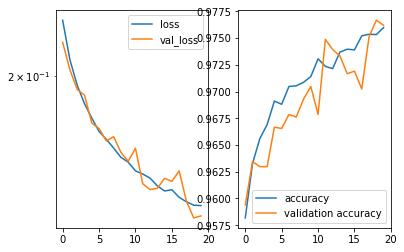

In [172]:
model.fit(x_train, y_train_labels, 
          batch_size=32, 
          validation_data=(x_val, y_val_labels),
          callbacks=[plot],
          verbose=0,
          epochs=20)

In [173]:
pred_val = model.predict_classes(x_val)

6496/8400 [======================>.......] - ETA: 19 - ETA: 0 - ETA:  - ETA: 0s

In [174]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.97619047619


In [175]:
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99       816
        1.0       0.99      0.99      0.99       909
        2.0       0.96      0.98      0.97       846
        3.0       0.99      0.96      0.97       937
        4.0       0.98      0.98      0.98       839
        5.0       0.99      0.96      0.97       702
        6.0       0.98      0.99      0.98       785
        7.0       0.97      0.98      0.97       893
        8.0       0.95      0.97      0.96       835
        9.0       0.98      0.96      0.97       838

avg / total       0.98      0.98      0.98      8400



In [176]:
print(confusion_matrix(y_val, pred_val))

[[811   1   1   0   0   0   0   2   0   1]
 [  1 901   1   0   2   0   1   1   2   0]
 [  1   3 832   1   0   1   0   7   1   0]
 [  1   0  15 901   1   3   1   3  10   2]
 [  2   3   1   0 821   0   4   1   2   5]
 [  1   0   0   4   2 672   9   1  12   1]
 [  3   1   0   0   1   1 777   0   2   0]
 [  0   1  14   1   2   0   0 872   0   3]
 [  2   0   5   5   7   0   3   3 807   3]
 [  5   0   1   1   4   2   0   8  11 806]]


In [177]:
#Train on all set
x_train = np.vstack((x_train,x_val))
y_train_labels = np.vstack((y_train_labels,y_val_labels))
x_train.shape, y_train_labels.shape 

((42000, 144), (42000, 10))

In [178]:
model.fit(x_train, y_train_labels, 
          batch_size=32, epochs=30)

Epoch 1/30
42000/42000 [==============================] - ETA: 15s - loss: 0.0563 - acc: 1.00 - ETA: 4s - loss: 0.1261 - acc: 0.9734 - ETA: 3s - loss: 0.1249 - acc: 0.971 - ETA: 3s - loss: 0.1238 - acc: 0.974 - ETA: 3s - loss: 0.1168 - acc: 0.974 - ETA: 2s - loss: 0.1157 - acc: 0.976 - ETA: 2s - loss: 0.1150 - acc: 0.976 - ETA: 2s - loss: 0.1122 - acc: 0.978 - ETA: 2s - loss: 0.1146 - acc: 0.977 - ETA: 2s - loss: 0.1142 - acc: 0.977 - ETA: 2s - loss: 0.1189 - acc: 0.975 - ETA: 2s - loss: 0.1172 - acc: 0.977 - ETA: 2s - loss: 0.1166 - acc: 0.977 - ETA: 2s - loss: 0.1146 - acc: 0.977 - ETA: 2s - loss: 0.1158 - acc: 0.976 - ETA: 2s - loss: 0.1156 - acc: 0.977 - ETA: 2s - loss: 0.1174 - acc: 0.976 - ETA: 1s - loss: 0.1167 - acc: 0.977 - ETA: 1s - loss: 0.1176 - acc: 0.977 - ETA: 1s - loss: 0.1183 - acc: 0.977 - ETA: 1s - loss: 0.1184 - acc: 0.976 - ETA: 1s - loss: 0.1179 - acc: 0.977 - ETA: 1s - loss: 0.1173 - acc: 0.977 - ETA: 1s - loss: 0.1169 - acc: 0.977 - ETA: 1s - loss: 0.1163 - acc:

42000/42000 [==============================] - ETA: 7s - loss: 0.2098 - acc: 0.906 - ETA: 3s - loss: 0.1143 - acc: 0.973 - ETA: 3s - loss: 0.1113 - acc: 0.975 - ETA: 2s - loss: 0.1068 - acc: 0.978 - ETA: 2s - loss: 0.1040 - acc: 0.979 - ETA: 2s - loss: 0.1071 - acc: 0.978 - ETA: 2s - loss: 0.1095 - acc: 0.978 - ETA: 2s - loss: 0.1091 - acc: 0.978 - ETA: 2s - loss: 0.1088 - acc: 0.978 - ETA: 2s - loss: 0.1086 - acc: 0.978 - ETA: 2s - loss: 0.1075 - acc: 0.978 - ETA: 2s - loss: 0.1078 - acc: 0.978 - ETA: 2s - loss: 0.1087 - acc: 0.978 - ETA: 2s - loss: 0.1089 - acc: 0.978 - ETA: 2s - loss: 0.1093 - acc: 0.978 - ETA: 2s - loss: 0.1089 - acc: 0.978 - ETA: 2s - loss: 0.1081 - acc: 0.978 - ETA: 2s - loss: 0.1084 - acc: 0.978 - ETA: 2s - loss: 0.1081 - acc: 0.978 - ETA: 2s - loss: 0.1085 - acc: 0.978 - ETA: 2s - loss: 0.1082 - acc: 0.978 - ETA: 2s - loss: 0.1085 - acc: 0.978 - ETA: 2s - loss: 0.1086 - acc: 0.977 - ETA: 2s - loss: 0.1085 - acc: 0.977 - ETA: 2s - loss: 0.1081 - acc: 0.977 - ETA

42000/42000 [==============================] - ETA: 6s - loss: 0.1875 - acc: 0.937 - ETA: 3s - loss: 0.1075 - acc: 0.979 - ETA: 2s - loss: 0.1030 - acc: 0.978 - ETA: 2s - loss: 0.1057 - acc: 0.978 - ETA: 2s - loss: 0.1065 - acc: 0.978 - ETA: 2s - loss: 0.1085 - acc: 0.977 - ETA: 2s - loss: 0.1043 - acc: 0.979 - ETA: 2s - loss: 0.1049 - acc: 0.979 - ETA: 2s - loss: 0.1045 - acc: 0.979 - ETA: 2s - loss: 0.1051 - acc: 0.979 - ETA: 1s - loss: 0.1081 - acc: 0.978 - ETA: 1s - loss: 0.1077 - acc: 0.978 - ETA: 1s - loss: 0.1064 - acc: 0.979 - ETA: 1s - loss: 0.1060 - acc: 0.979 - ETA: 1s - loss: 0.1059 - acc: 0.979 - ETA: 1s - loss: 0.1039 - acc: 0.980 - ETA: 1s - loss: 0.1038 - acc: 0.980 - ETA: 1s - loss: 0.1034 - acc: 0.980 - ETA: 1s - loss: 0.1049 - acc: 0.979 - ETA: 1s - loss: 0.1051 - acc: 0.979 - ETA: 1s - loss: 0.1056 - acc: 0.979 - ETA: 1s - loss: 0.1066 - acc: 0.979 - ETA: 1s - loss: 0.1074 - acc: 0.978 - ETA: 1s - loss: 0.1071 - acc: 0.978 - ETA: 1s - loss: 0.1064 - acc: 0.978 - ETA

42000/42000 [==============================] - ETA: 9s - loss: 0.0561 - acc: 1.000 - ETA: 3s - loss: 0.1149 - acc: 0.981 - ETA: 2s - loss: 0.1121 - acc: 0.980 - ETA: 2s - loss: 0.1032 - acc: 0.983 - ETA: 2s - loss: 0.0981 - acc: 0.984 - ETA: 2s - loss: 0.1036 - acc: 0.983 - ETA: 2s - loss: 0.1013 - acc: 0.983 - ETA: 2s - loss: 0.0993 - acc: 0.982 - ETA: 2s - loss: 0.1026 - acc: 0.981 - ETA: 2s - loss: 0.1024 - acc: 0.981 - ETA: 2s - loss: 0.1038 - acc: 0.981 - ETA: 2s - loss: 0.1026 - acc: 0.981 - ETA: 2s - loss: 0.1035 - acc: 0.980 - ETA: 2s - loss: 0.1028 - acc: 0.981 - ETA: 2s - loss: 0.1035 - acc: 0.981 - ETA: 2s - loss: 0.1030 - acc: 0.981 - ETA: 2s - loss: 0.1023 - acc: 0.981 - ETA: 1s - loss: 0.1014 - acc: 0.981 - ETA: 1s - loss: 0.1005 - acc: 0.981 - ETA: 1s - loss: 0.1001 - acc: 0.981 - ETA: 1s - loss: 0.0999 - acc: 0.981 - ETA: 1s - loss: 0.1006 - acc: 0.981 - ETA: 1s - loss: 0.1005 - acc: 0.981 - ETA: 1s - loss: 0.1007 - acc: 0.981 - ETA: 1s - loss: 0.1011 - acc: 0.981 - ETA

42000/42000 [==============================] - ETA: 7s - loss: 0.2047 - acc: 0.937 - ETA: 2s - loss: 0.0934 - acc: 0.981 - ETA: 2s - loss: 0.0952 - acc: 0.982 - ETA: 2s - loss: 0.0945 - acc: 0.984 - ETA: 2s - loss: 0.0939 - acc: 0.983 - ETA: 2s - loss: 0.0963 - acc: 0.982 - ETA: 2s - loss: 0.0973 - acc: 0.981 - ETA: 2s - loss: 0.0988 - acc: 0.981 - ETA: 1s - loss: 0.0991 - acc: 0.980 - ETA: 1s - loss: 0.0977 - acc: 0.981 - ETA: 1s - loss: 0.0980 - acc: 0.981 - ETA: 1s - loss: 0.0997 - acc: 0.980 - ETA: 1s - loss: 0.1007 - acc: 0.980 - ETA: 1s - loss: 0.1021 - acc: 0.980 - ETA: 1s - loss: 0.1034 - acc: 0.979 - ETA: 1s - loss: 0.1041 - acc: 0.979 - ETA: 1s - loss: 0.1032 - acc: 0.980 - ETA: 1s - loss: 0.1040 - acc: 0.979 - ETA: 1s - loss: 0.1048 - acc: 0.979 - ETA: 1s - loss: 0.1052 - acc: 0.979 - ETA: 1s - loss: 0.1056 - acc: 0.978 - ETA: 1s - loss: 0.1050 - acc: 0.979 - ETA: 1s - loss: 0.1042 - acc: 0.979 - ETA: 1s - loss: 0.1036 - acc: 0.979 - ETA: 1s - loss: 0.1034 - acc: 0.979 - ETA

42000/42000 [==============================] - ETA: 6s - loss: 0.0774 - acc: 1.000 - ETA: 2s - loss: 0.0926 - acc: 0.981 - ETA: 2s - loss: 0.0938 - acc: 0.981 - ETA: 2s - loss: 0.0904 - acc: 0.982 - ETA: 2s - loss: 0.0941 - acc: 0.981 - ETA: 2s - loss: 0.0972 - acc: 0.979 - ETA: 2s - loss: 0.1005 - acc: 0.979 - ETA: 2s - loss: 0.1029 - acc: 0.979 - ETA: 2s - loss: 0.1030 - acc: 0.978 - ETA: 1s - loss: 0.1020 - acc: 0.979 - ETA: 1s - loss: 0.1028 - acc: 0.979 - ETA: 1s - loss: 0.1014 - acc: 0.979 - ETA: 1s - loss: 0.1029 - acc: 0.978 - ETA: 1s - loss: 0.1033 - acc: 0.978 - ETA: 1s - loss: 0.1018 - acc: 0.979 - ETA: 1s - loss: 0.1009 - acc: 0.979 - ETA: 1s - loss: 0.1021 - acc: 0.979 - ETA: 1s - loss: 0.1007 - acc: 0.979 - ETA: 1s - loss: 0.1013 - acc: 0.979 - ETA: 1s - loss: 0.1004 - acc: 0.980 - ETA: 1s - loss: 0.1001 - acc: 0.980 - ETA: 1s - loss: 0.1004 - acc: 0.980 - ETA: 1s - loss: 0.1006 - acc: 0.979 - ETA: 1s - loss: 0.1007 - acc: 0.980 - ETA: 1s - loss: 0.1002 - acc: 0.980 - ETA

42000/42000 [==============================] - ETA: 7s - loss: 0.0432 - acc: 1.000 - ETA: 3s - loss: 0.0904 - acc: 0.981 - ETA: 3s - loss: 0.0808 - acc: 0.987 - ETA: 3s - loss: 0.0788 - acc: 0.986 - ETA: 3s - loss: 0.0778 - acc: 0.986 - ETA: 3s - loss: 0.0786 - acc: 0.987 - ETA: 3s - loss: 0.0808 - acc: 0.986 - ETA: 3s - loss: 0.0833 - acc: 0.984 - ETA: 3s - loss: 0.0862 - acc: 0.983 - ETA: 3s - loss: 0.0866 - acc: 0.983 - ETA: 3s - loss: 0.0875 - acc: 0.983 - ETA: 2s - loss: 0.0883 - acc: 0.983 - ETA: 2s - loss: 0.0867 - acc: 0.984 - ETA: 2s - loss: 0.0894 - acc: 0.983 - ETA: 2s - loss: 0.0892 - acc: 0.982 - ETA: 2s - loss: 0.0899 - acc: 0.982 - ETA: 2s - loss: 0.0902 - acc: 0.982 - ETA: 2s - loss: 0.0914 - acc: 0.981 - ETA: 2s - loss: 0.0909 - acc: 0.981 - ETA: 2s - loss: 0.0913 - acc: 0.981 - ETA: 2s - loss: 0.0916 - acc: 0.981 - ETA: 2s - loss: 0.0922 - acc: 0.981 - ETA: 2s - loss: 0.0918 - acc: 0.981 - ETA: 2s - loss: 0.0924 - acc: 0.981 - ETA: 2s - loss: 0.0922 - acc: 0.982 - ETA

42000/42000 [==============================] - ETA: 9s - loss: 0.1034 - acc: 0.968 - ETA: 3s - loss: 0.0935 - acc: 0.980 - ETA: 2s - loss: 0.1007 - acc: 0.977 - ETA: 2s - loss: 0.0933 - acc: 0.980 - ETA: 2s - loss: 0.0926 - acc: 0.981 - ETA: 2s - loss: 0.0924 - acc: 0.981 - ETA: 2s - loss: 0.0921 - acc: 0.981 - ETA: 2s - loss: 0.0921 - acc: 0.981 - ETA: 2s - loss: 0.0928 - acc: 0.980 - ETA: 2s - loss: 0.0948 - acc: 0.980 - ETA: 2s - loss: 0.0950 - acc: 0.980 - ETA: 2s - loss: 0.0967 - acc: 0.980 - ETA: 2s - loss: 0.0960 - acc: 0.980 - ETA: 1s - loss: 0.0980 - acc: 0.979 - ETA: 1s - loss: 0.0980 - acc: 0.980 - ETA: 1s - loss: 0.0969 - acc: 0.980 - ETA: 1s - loss: 0.0964 - acc: 0.980 - ETA: 1s - loss: 0.0968 - acc: 0.980 - ETA: 1s - loss: 0.0961 - acc: 0.981 - ETA: 1s - loss: 0.0965 - acc: 0.981 - ETA: 1s - loss: 0.0964 - acc: 0.981 - ETA: 1s - loss: 0.0965 - acc: 0.981 - ETA: 1s - loss: 0.0970 - acc: 0.981 - ETA: 1s - loss: 0.0966 - acc: 0.981 - ETA: 1s - loss: 0.0967 - acc: 0.981 - ETA

42000/42000 [==============================] - ETA: 14s - loss: 0.0740 - acc: 1.00 - ETA: 4s - loss: 0.0820 - acc: 0.9885 - ETA: 3s - loss: 0.0951 - acc: 0.986 - ETA: 3s - loss: 0.0945 - acc: 0.985 - ETA: 3s - loss: 0.0940 - acc: 0.985 - ETA: 3s - loss: 0.0934 - acc: 0.984 - ETA: 3s - loss: 0.0925 - acc: 0.984 - ETA: 2s - loss: 0.0915 - acc: 0.984 - ETA: 2s - loss: 0.0928 - acc: 0.983 - ETA: 2s - loss: 0.0938 - acc: 0.983 - ETA: 2s - loss: 0.0939 - acc: 0.983 - ETA: 2s - loss: 0.0947 - acc: 0.983 - ETA: 2s - loss: 0.0949 - acc: 0.982 - ETA: 2s - loss: 0.0952 - acc: 0.983 - ETA: 2s - loss: 0.0939 - acc: 0.983 - ETA: 2s - loss: 0.0930 - acc: 0.983 - ETA: 2s - loss: 0.0919 - acc: 0.984 - ETA: 2s - loss: 0.0921 - acc: 0.984 - ETA: 2s - loss: 0.0911 - acc: 0.984 - ETA: 2s - loss: 0.0916 - acc: 0.984 - ETA: 2s - loss: 0.0904 - acc: 0.984 - ETA: 2s - loss: 0.0923 - acc: 0.983 - ETA: 2s - loss: 0.0938 - acc: 0.983 - ETA: 2s - loss: 0.0931 - acc: 0.983 - ETA: 2s - loss: 0.0935 - acc: 0.983 - ET

42000/42000 [==============================] - ETA: 9s - loss: 0.0988 - acc: 0.968 - ETA: 3s - loss: 0.0861 - acc: 0.988 - ETA: 3s - loss: 0.0840 - acc: 0.987 - ETA: 3s - loss: 0.0897 - acc: 0.983 - ETA: 2s - loss: 0.0895 - acc: 0.982 - ETA: 2s - loss: 0.0924 - acc: 0.981 - ETA: 2s - loss: 0.0919 - acc: 0.981 - ETA: 2s - loss: 0.0902 - acc: 0.981 - ETA: 2s - loss: 0.0915 - acc: 0.981 - ETA: 2s - loss: 0.0909 - acc: 0.981 - ETA: 2s - loss: 0.0915 - acc: 0.981 - ETA: 2s - loss: 0.0917 - acc: 0.980 - ETA: 2s - loss: 0.0929 - acc: 0.980 - ETA: 2s - loss: 0.0924 - acc: 0.980 - ETA: 2s - loss: 0.0940 - acc: 0.979 - ETA: 2s - loss: 0.0929 - acc: 0.980 - ETA: 2s - loss: 0.0932 - acc: 0.980 - ETA: 2s - loss: 0.0938 - acc: 0.979 - ETA: 2s - loss: 0.0929 - acc: 0.980 - ETA: 2s - loss: 0.0920 - acc: 0.980 - ETA: 2s - loss: 0.0912 - acc: 0.980 - ETA: 2s - loss: 0.0913 - acc: 0.980 - ETA: 2s - loss: 0.0917 - acc: 0.980 - ETA: 1s - loss: 0.0915 - acc: 0.981 - ETA: 1s - loss: 0.0922 - acc: 0.981 - ETA

In [180]:
pred_test = model.predict_classes(hog_test)

26592/28000 [===========================>..] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA: 0s

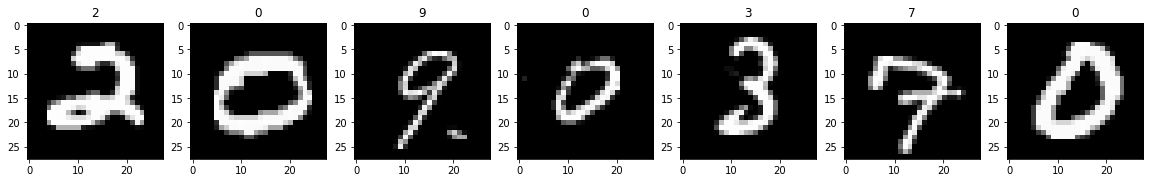

In [181]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [182]:
with open('submit_nn.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [223]:
!head submit.txt

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [270]:
# Your submission scored 0.41700